# Data
## First approaches
### Imagery (Surface Reflectance)

In [ ]:
# description: https://www.usgs.gov/landsat-missions/landsat-collection-2-surface-reflectance
# metadata: https://d9-wret.s3.us-west-2.amazonaws.com/assets/palladium/production/s3fs-public/media/files/LSDS-1618_Landsat-4-7_C2-L2-ScienceProductGuide-v4.pdf

In [1]:
import xarray as xr
import rioxarray as rxr

In [4]:
red = rxr.open_rasterio("/Users/felixschulz/Library/CloudStorage/OneDrive-Persönlich/Dokumente/Uni/Masterthesis/data/imagery/landsat/Landsat 4-5 TM Collection 2 Level-2/LT05_L2SP_175084_19840609_20200918_02_T1/LT05_L2SP_175084_19840609_20200918_02_T1_SR_B3.TIF")
green = rxr.open_rasterio("/Users/felixschulz/Library/CloudStorage/OneDrive-Persönlich/Dokumente/Uni/Masterthesis/data/imagery/landsat/Landsat 4-5 TM Collection 2 Level-2/LT05_L2SP_175084_19840609_20200918_02_T1/LT05_L2SP_175084_19840609_20200918_02_T1_SR_B2.TIF")
blue = rxr.open_rasterio("/Users/felixschulz/Library/CloudStorage/OneDrive-Persönlich/Dokumente/Uni/Masterthesis/data/imagery/landsat/Landsat 4-5 TM Collection 2 Level-2/LT05_L2SP_175084_19840609_20200918_02_T1/LT05_L2SP_175084_19840609_20200918_02_T1_SR_B1.TIF")

In [ ]:
scaled_red = xr.where(red != 0, (red - 1) / (65535 - 1), 0)
scaled_green = xr.where(green != 0, (green - 1) / (65535 - 1), 0)
scaled_blue = xr.where(blue != 0, (blue - 1) / (65535 - 1), 0)

In [5]:
test = xr.combine_nested([green, red, blue], concat_dim = "band")

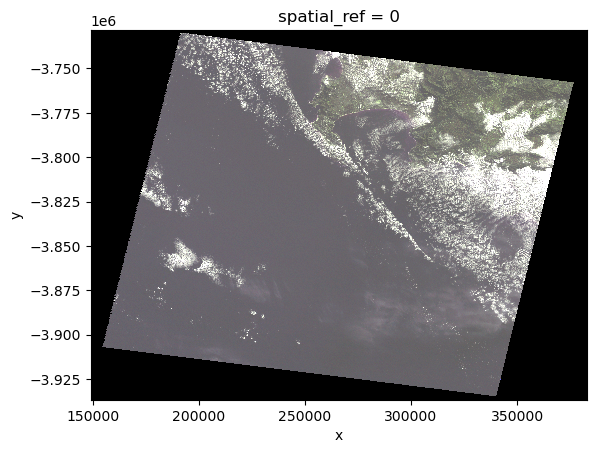

In [6]:
xr.plot.imshow(test, rgb = "band", robust = True)

In [63]:
cloud = rxr.open_rasterio("/Users/felixschulz/Library/CloudStorage/OneDrive-Persönlich/Dokumente/Uni/Master Thesis/data/imagery/landsat/Landsat 4-5 TM Collection 2 Level-2/LT05_L2SP_175084_19840609_20200918_02_T1/LT05_L2SP_175084_19840609_20200918_02_T1_SR_CLOUD_QA.TIF")

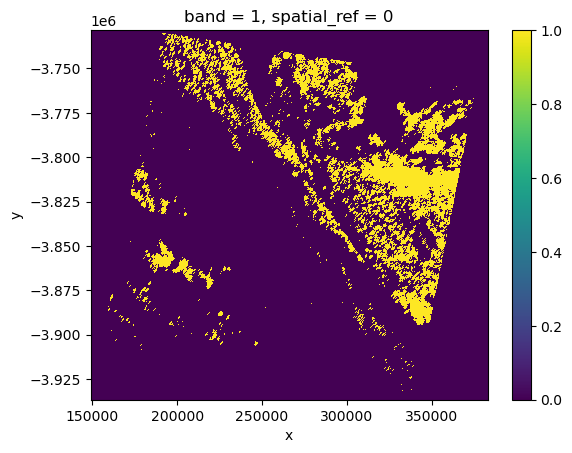

In [70]:
cloud.squeeze().isin([2, 34, 4, 12, 20, 36, 52, 8, 12, 24, 40, 56]).plot.imshow()

In [71]:
cloud_dist = rxr.open_rasterio("/Users/felixschulz/Library/CloudStorage/OneDrive-Persönlich/Dokumente/Uni/Master Thesis/data/imagery/landsat/Landsat 4-5 TM Collection 2 Level-2/LT05_L2SP_175084_19840609_20200918_02_T1/LT05_L2SP_175084_19840609_20200918_02_T1_ST_CDIST.TIF")

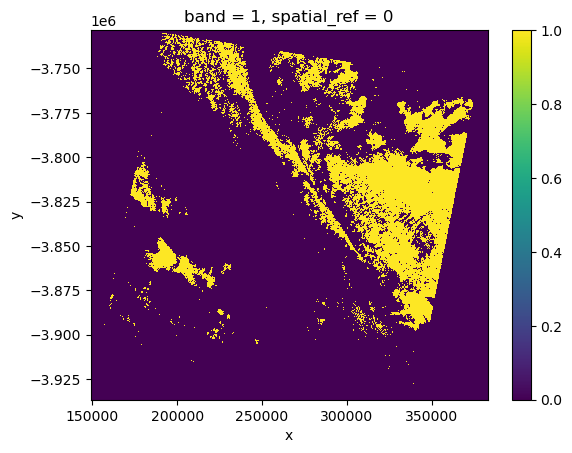

In [76]:
((cloud_dist.squeeze() > -5000) & (cloud_dist.squeeze() <= .1)).plot.imshow()

In [84]:
red_filtered = red.squeeze().where(cloud_dist.squeeze() > .1)

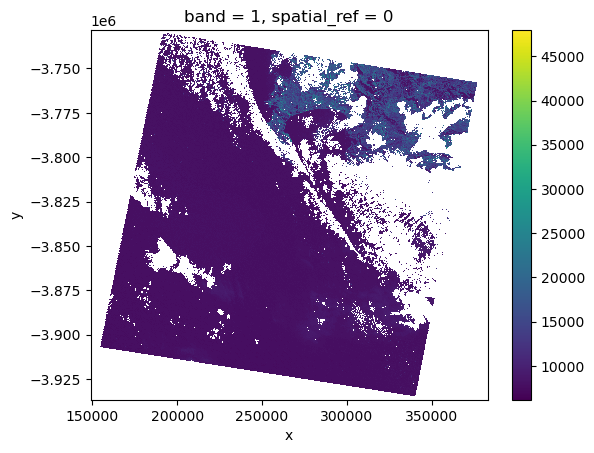

In [85]:
red_filtered.plot.imshow()

#### API

In [1]:
import requests
import geopandas as gpd
import shapely
import time

In [2]:
# login
response = requests.post("https://m2m.cr.usgs.gov/api/api/json/stable/login",
                         json = {"username": "felixschulz", "password": "wuJzid-5rutqo-dercib"})
API_key = response.json()["data"]

In [3]:
# get all datasets
response = requests.post("https://m2m.cr.usgs.gov/api/api/json/stable/dataset-search",
                         headers = {"X-Auth-Token": API_key})

In [4]:
([{x["collectionName"]: x["datasetAlias"]} for x in response.json()["data"]])[1000:]

[{'Aerial Photo Single Frames': 'aerial_combin'},
 {'Aircraft Scanners': 'aircraft_scanners'},
 {'Algeria 3': 'calval_pis_algeria_3'},
 {'Algeria 5': 'calval_pis_algeria_5'},
 {'Antarctic Flight Line Maps': 'aerial_usarc_index'},
 {'Antarctic Single Frames': 'aerial_usarc'},
 {'ASAS': 'asas'},
 {'ASTER GED AG100': 'aster_ged_ag100'},
 {'ASTER GED AG1KM': 'aster_ged_ag1km'},
 {'ASTER GED AG5KMMOH V41': 'aster_ged_ag5kmmoh'},
 {'ASTER GED C2 Subset': 'atmo_aux_aster_ged'},
 {'ASTER Global DEM V3': 'aster_global_dem_v3'},
 {'ASTER Level 1T V3': 'aster_l1t'},
 {'ASTER Water Bodies Database V1': 'astwbd'},
 {'AVHRR Composites': 'avhrr_composite'},
 {'AVHRR Global 1K': 'avhrr_1k_global_comp'},
 {'AVHRR Orbital Segment': 'avhrr_orbseg'},
 {'AVHRR Phenology': 'avhrr_phen_metrics'},
 {'CAM5K30CF V2': 'cam5k30cf_v2'},
 {'CAM5K30EM V2': 'cam5k30em_v2'},
 {'CAM5K30UC V2': 'cam5k30uc_v2'},
 {'CCDC V1.0 (HI)': 'ccdc_v1_0_hi'},
 {'CCDC V1.1 (CONUS)': 'ccdc_v1_1'},
 {'CCDC V1.2 (CONUS)': 'ccdc_v1_2'},

In [5]:
boundaries = gpd.read_file("/Users/felixschulz/Library/CloudStorage/OneDrive-Persönlich/Dokumente/Uni/Masterthesis/data/boundaries/gadm41_ZAF_0.json")

In [78]:
# get all scenes
scene_list = []
it_starting_number = 0
it_next_record = 1001
it_total_hits = 0
while (it_total_hits != it_next_record):
    time.sleep(1)
    # do the API request
    response = requests.post("https://m2m.cr.usgs.gov/api/api/json/stable/scene-search",
                            json = {"datasetName": "landsat_etm_c2_l2",
                                    "maxResults": 1000,
                                    "startingNumber": it_starting_number,
                                    "sceneFilter": {"acquisitionFilter": {"start": "2015-01-01", "end": "2015-12-31"},
                                                    "spatialFilter": {"filterType": "mbr", 
                                                                    "lowerLeft": {"latitude": boundaries.total_bounds[1], "longitude": boundaries.total_bounds[0]},
                                                                    "upperRight": {"latitude": boundaries.total_bounds[3], "longitude": boundaries.total_bounds[2]}}}},
                            headers = {"X-Auth-Token": API_key})
    # set for the next iteration
    if it_starting_number == 0:
        it_total_hits = response.json()["data"]["totalHits"]
    it_starting_number = it_next_record
    it_next_record = response.json()["data"]["nextRecord"]
    # process results
    res_polygons = gpd.GeoDataFrame({"productId": [x["browse"]["id"] for x in response.json()["data"]["results"]],
                                     "entityId": [x["entityId"] for x in response.json()["data"]["results"]],
                                 "geometry": [shapely.Polygon(x["spatialBounds"]["coordinates"][0]) for x in response.json()["data"]["results"]]},
                                crs = "EPSG:4326")
    #
    scene_list += res_polygons.loc[res_polygons.intersects(boundaries.geometry.iloc[0]), "entityId"].values.tolist()

In [72]:
# add to scene list
response = requests.post("https://m2m.cr.usgs.gov/api/api/json/stable/scene-list-add",
                        json = {"listId": "za_ls7_2015",
                                "datasetName": "landsat_etm_c2_l2",
                                "entityIds": scene_list},
                        headers = {"X-Auth-Token": API_key})

In [74]:
# check scene list
response = requests.post("https://m2m.cr.usgs.gov/api/api/json/stable/scene-list-summary",
                        json = {"listId": "za_ls7_2015",
                                "datasetName": "landsat_etm_c2_l2"},
                        headers = {"X-Auth-Token": API_key})

In [3]:
#
response = requests.post("https://m2m.cr.usgs.gov/api/api/json/stable/download-options",
                        json = {"listId": "za_ls7_2015",
                                "datasetName": "landsat_etm_c2_l2"},
                        headers = {"X-Auth-Token": API_key}) 

In [ ]:
response.json()

In [7]:
#
response = requests.post("https://m2m.cr.usgs.gov/api/api/json/stable/download-request",
                        json = {"downloads": [{"label": "test",
                                              "entityId": "L2ST_LE07_L2SP_167078_20150106_20200905_02_T1_ANG_TXT",
                                              "productId": "5f85f041a2ea6695"}]},
                        headers = {"X-Auth-Token": API_key}) 

In [8]:
response.json()

{'requestId': 1244933364,
 'version': 'stable',
 'sessionId': 207214705,
 'data': {'availableDownloads': [{'downloadId': 387313652,
    'eulaCode': None,
    'url': 'https://landsatlook.usgs.gov/data/collection02/level-2/standard/etm/2015/167/078/LE07_L2SP_167078_20150106_20200905_02_T1/LE07_L2SP_167078_20150106_20200905_02_T1_ANG.txt?requestSignature=eyJjb250YWN0SWQiOjI2MjU3NTIxLCJkb3dubG9hZElkIjozODczMTM2NTIsImRhdGVHZW5lcmF0ZWQiOiIyMDIzLTA0LTI4VDAzOjM4OjI1LTA1OjAwIiwiaWQiOiJMRTA3X0wyU1BfMTY3MDc4XzIwMTUwMTA2XzIwMjAwOTA1XzAyX1QxX0FORy50eHQiLCJzaWduYXR1cmUiOiIkNSQkYUExXC9JNmRzd2RGWTVDTFh2VmtcL1Q4WnZCZXdkQUwzNFZVbXVhQnQ0UHNEIn0='}],
  'duplicateProducts': [],
  'preparingDownloads': [],
  'failed': [],
  'newRecords': {'387313652': 'test'},
  'numInvalidScenes': 0},
 'errorCode': None,
 'errorMessage': None}

In [10]:
#
response = requests.post("https://m2m.cr.usgs.gov/api/api/json/stable/logout",
                         headers = {"X-Auth-Token": API_key}) 

In [9]:
import urllib.request
urllib.request.urlretrieve('https://landsatlook.usgs.gov/data/collection02/level-2/standard/etm/2015/167/078/LE07_L2SP_167078_20150106_20200905_02_T1/LE07_L2SP_167078_20150106_20200905_02_T1_ANG.txt?requestSignature=eyJjb250YWN0SWQiOjI2MjU3NTIxLCJkb3dubG9hZElkIjozODczMTM2NTIsImRhdGVHZW5lcmF0ZWQiOiIyMDIzLTA0LTI4VDAzOjM4OjI1LTA1OjAwIiwiaWQiOiJMRTA3X0wyU1BfMTY3MDc4XzIwMTUwMTA2XzIwMjAwOTA1XzAyX1QxX0FORy50eHQiLCJzaWduYXR1cmUiOiIkNSQkYUExXC9JNmRzd2RGWTVDTFh2VmtcL1Q4WnZCZXdkQUwzNFZVbXVhQnQ0UHNEIn0=', "/Users/felixschulz/Desktop/test.txt")

('/Users/felixschulz/Desktop/test.txt',
 <http.client.HTTPMessage at 0x111a9bbe0>)

In [39]:
res_polygons = gpd.GeoDataFrame({"entityId": [x["entityId"] for x in response.json()["data"]["results"]],
                                 "geometry": [shapely.Polygon(x["spatialBounds"]["coordinates"][0]) for x in response.json()["data"]["results"]]},
                                crs = "EPSG:4326")

In [49]:
res_polygons.loc[res_polygons.intersects(boundaries.geometry.iloc[0]), "entityId"]

1      LE71680762015365SG100
2      LE71680772015365SG100
3      LE71680782015365SG100
4      LE71680792015365SG100
5      LE71680802015365SG100
               ...          
995    LE71680802015173SG100
996    LE71680812015173SG100
997    LE71700752015171SG100
998    LE71700762015171SG100
999    LE71700772015171SG100
Name: entityId, Length: 790, dtype: object

In [ ]:
"Landsat 7 ETM+ C2 L2": "landsat_etm_c2_l2", "Landsat 4-5 TM C2 L2": "landsat_tm_c2_l2"

### Ground Truth (Land Cover)

In [ ]:
# viewer: https://land.copernicus.eu/global/lcviewer
# data: https://zenodo.org/record/3939038#.ZEY84i-21qs

In [2]:
import xarray as xr
import rioxarray as rxr
import numpy as np

In [2]:
cloud_dist = rxr.open_rasterio("/Users/felixschulz/Library/CloudStorage/OneDrive-Persönlich/Dokumente/Uni/Master Thesis/data/imagery/landsat/Landsat 4-5 TM Collection 2 Level-2/LT05_L2SP_175084_19840609_20200918_02_T1/LT05_L2SP_175084_19840609_20200918_02_T1_ST_CDIST.TIF")

In [6]:
land_cover = rxr.open_rasterio("/Users/felixschulz/Library/CloudStorage/OneDrive-Persönlich/Dokumente/Uni/Master Thesis/data/land cover/PROBAV_LC100_global_v3.0.1_2015-base_Discrete-Classification-map_EPSG-4326.tif")

In [17]:
land_cover_sample = land_cover.squeeze().rio.clip_box(*cloud_dist.rio.reproject("EPSG:4326").rio.bounds())

In [23]:
np.unique(land_cover_sample, return_counts = True)

(array([ 20,  30,  40,  50,  60,  80,  90, 112, 114, 115, 116, 122, 124,
        125, 126, 200], dtype=uint8),
 array([ 135584,  542080,  214011,   69897,     537,   14861,    5683,
           1597,     930,       6,   10442,       2,      72,       1,
          31826, 4080041]))

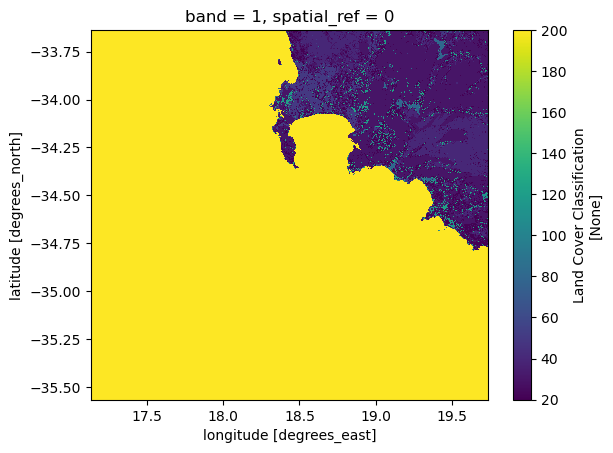

In [16]:
land_cover.squeeze().rio.clip_box(*cloud_dist.rio.reproject("EPSG:4326").rio.bounds()).plot.imshow()

### Auxiliary Data
#### Biome Clusters

In [5]:
import geopandas as gpd

In [8]:
# biome clusters
# see https://zenodo.org/record/5848610#.ZEZ4Py-21qs
biome_clusters = gpd.read_file("/Users/felixschulz/Library/CloudStorage/OneDrive-Persönlich/Dokumente/Uni/Master Thesis/data/biome clusters/biome_cluster_shapefile/ProbaV_UTM_LC100_biome_clusters_V3_global.shp")

<Axes: >

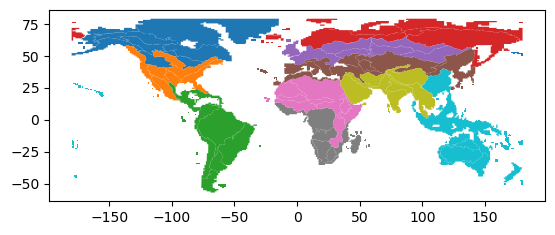

In [14]:
biome_clusters.plot(column = "bc_id")

#### Elevation

In [15]:
import xarray as xr
import rioxarray as rxr

In [17]:
# https://www.usgs.gov/centers/eros/science/usgs-eros-archive-digital-elevation-shuttle-radar-topography-mission-srtm-1
elevation = rxr.open_rasterio("/Users/felixschulz/Library/CloudStorage/OneDrive-Persönlich/Dokumente/Uni/Master Thesis/data/DTM/srtm_40_19/srtm_40_19.tif")

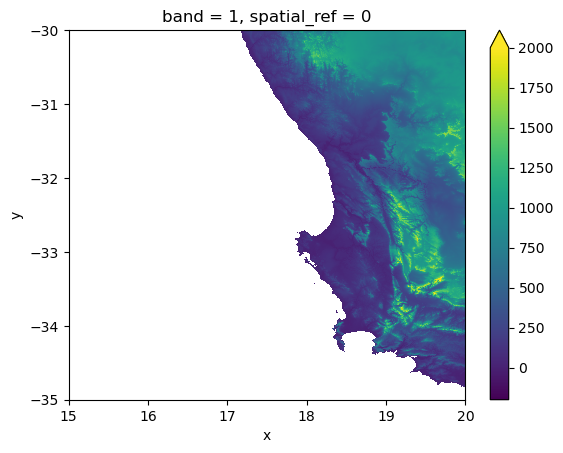

In [20]:
elevation.where(elevation >= -200).squeeze().plot.imshow(vmin = -200, vmax = 2000)

---

### Image Data
#### Grid

In [31]:
import numpy as np
import pandas as pd
import geopandas as gpd

import xarray as xr
import rioxarray as rxr
import shapely

import matplotlib.pyplot as plt
import re
from geocube.api.core import make_geocube
from geocube.rasterize import rasterize_points_griddata

In [2]:
ex_empty = rxr.open_rasterio("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/mapbiomas_2010_0000000000-0000000000.tif")
ex_full = rxr.open_rasterio("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/mapbiomas_2010_0000000000-0000046592.tif")

In [146]:
ex_test = rxr.open_rasterio("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/mapbiomas_20150000006656-0000093184.tif")

In [148]:
def get_grid_no(filename):
    return np.int32(re.findall(r"(\d{10})", filename)) / 3328

get_grid_no("mapbiomas_2015_0000006656-0000093184.tif")

array([ 2., 28.])

In [3]:
boundaries = gpd.read_file("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/boundaries/gadm_410-BRA.geojson",
                           engine = "pyogrio").to_crs(5641)

In [67]:
min_x = int(np.min(ex_empty.x.to_numpy()))
max_x = int(boundaries.total_bounds[2])
step_x = (30 * len(ex_empty.x))
grid_cells_x = int(((max_x - min_x) // step_x)) + 2
#
min_y = int(boundaries.total_bounds[1])
max_y = int(np.max(ex_empty.y.to_numpy())) + 30
step_y = (30 * len(ex_empty.y))
grid_cells_y = int((max_y - min_y) // step_y) + 2

In [68]:
xv, yv = np.meshgrid(np.array([min_x + i * step_x for i in range(grid_cells_x)]),
                     np.array([max_y - i * step_y for i in range(grid_cells_y)]))

In [139]:
# create boxes from grid
boxes = gpd.GeoDataFrame(dict(Row = np.repeat(range(len(xv) - 1), len(xv[0]) - 1),
                              Column = np.tile(range(len(xv[0]) - 1), len(xv) - 1)),
                         geometry = [shapely.box(xv[i, j], yv[i, j] - 30, xv[i, j + 1] - 30, yv[i + 1, j]) for i in range(len(xv) - 1) for j in range(len(xv[0]) - 1)],
                         crs = 5641)

boxes.reset_index(names = "CellID", inplace = True)

boxes[["X", "Y"]] = pd.DataFrame(boxes.exterior.map(lambda x: [min(y) for y in x.xy]).to_list(), columns = ["x", "y"])

boxes["Internal"] = boxes.intersects(boundaries.geometry.iloc[0])

<Axes: >

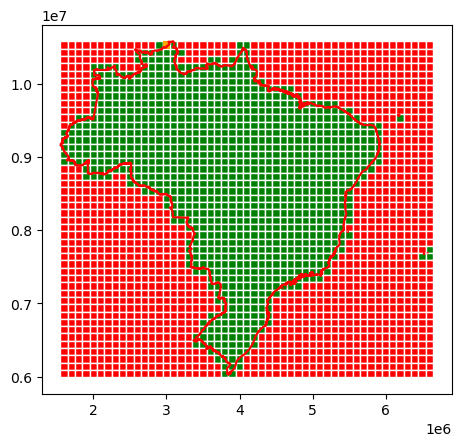

In [140]:
ax = boxes.plot(edgecolor="white", color = boxes.Internal.map({True: "green", False: "red"}))
boundaries.boundary.plot(ax = ax, color = "red")
boxes.iloc[[14]].plot(ax = ax, color = "orange")

In [143]:
import sqlite3
conn = sqlite3.connect('/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/imagery/imagery.db')

# insert data into GridCells table
boxes.drop(columns="geometry").to_sql("GridCells", conn, if_exists = "replace", index = False)

# store geometries externally
boxes[["CellID", "geometry"]].to_feather("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/imagery/grid_cells.feather")

---
#### Final Setup

In [2]:
import io
import sqlite3

import numpy as np
import pandas as pd
import geopandas as gpd
import shapely
import xarray as xr
import rioxarray as rxr
import rasterio
from rasterio.io import MemoryFile
from geocube.api.core import make_geocube

from google.cloud import storage

In [3]:
# connect to database
conn = sqlite3.connect('/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/imagery/imagery.db')
# get grid data
grid_data = pd.read_sql_query("SELECT * FROM GridCells WHERE Internal=1", conn)
# get grid geometries
grid_geoms = gpd.read_feather("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/imagery/grid_cells.feather")
# merge data
grid_data = gpd.GeoDataFrame(grid_data.merge(grid_geoms, on = "CellID"))
# close connection
conn.close()

<Axes: >

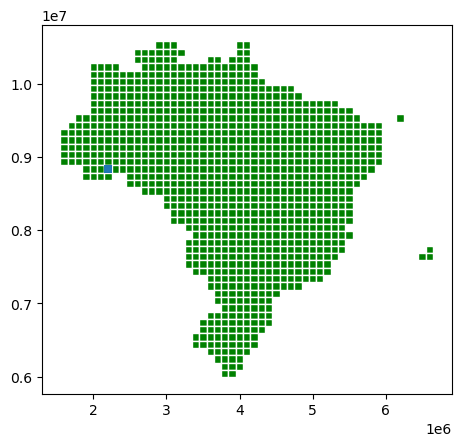

In [51]:
ax = grid_data.plot(edgecolor="white", color = grid_data.Internal.map({1: "green", 0: "red"}))
grid_data[((grid_data.Row == 17) & (grid_data.Column == 6))].plot(ax = ax)

In [4]:
# Initialize the GCS client
client = storage.Client("master-thesis-414809")

# Get the bucket
bucket = client.get_bucket("master-thesis-lulc")

# List files in the bucket
blobs = np.array(list(bucket.list_blobs()))

# Extract file names
file_names = np.array([blob.name for blob in blobs])

In [6]:
i = 525

In [7]:
cell = grid_data.iloc[[i]]

#
def get_grid_name(cell):
    return "mapbiomas/2010_{:010d}-{:010d}.tif".format(*(cell[["Row", "Column"]].to_numpy() * 3328)[0])

# Download a .tif file as bytes
file_bytes = blobs[(file_names == get_grid_name(cell))][0].download_as_string()

# Create a virtual file-like object
virtual_file = io.BytesIO(file_bytes)

# Open the virtual file as a rasterio dataset
with rasterio.open(virtual_file) as dataset:
    imagery = rxr.open_rasterio(virtual_file)

In [8]:
# get land cover shapefile
lc_ibge = gpd.read_feather("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/land_cover/raw/lc_ibge_2010.feather")

In [9]:
# get land cover data
lc_ibge_data = lc_ibge.loc[lc_ibge.intersects(cell.geometry.iloc[0]), :]

#
bbox = gpd.GeoSeries(shapely.geometry.box(*cell.total_bounds), crs="EPSG:5641")
geom = bbox.__geo_interface__["features"][0]["geometry"]
geom["crs"] = {"properties": {"name": "EPSG:5641"}}

# create xarray
out = make_geocube(
    vector_data = lc_ibge_data,
    measurements = ["GRIDCODE"],
    output_crs = "EPSG:5641",
    fill = 65535,
    geom = geom,
    align = (0, 0),
    resolution = [-30, 30]
)

In [10]:
out = xr.concat([imagery, out.GRIDCODE.assign_coords({"band": 7})], dim="band")
out.attrs["long_name"] += tuple(["lc_ibge"])

In [11]:
fetch_instructions = pd.read_json("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/setup/fetch.json")
def get_fetch_instructions(id):
    return fetch_instructions[fetch_instructions["id"] == id].to_dict(orient = "records")[0]

In [12]:
lc_glc_list = [rxr.open_rasterio(f"/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/land_cover/raw/{f}", chunks = True) for f in get_fetch_instructions("lc_glc_30")["url"]["files"]]
lc_glc_combined = xr.combine_by_coords(lc_glc_list).sel(band = 1)

In [13]:
cell_exterior = cell.to_crs(4326).exterior.iloc[0].coords.xy

In [14]:
lc_glc_combined_subset = lc_glc_combined.sel(
    dict(x = np.arange(cell_exterior[0][2] - 1, cell_exterior[0][1] + 1, 0.00025),
         y = np.arange(cell_exterior[1][1] - 1, cell_exterior[1][0] + 1, 0.00025)), 
    method = "nearest").load()

In [15]:
out = xr.concat([out, lc_glc_combined_subset.rio.reproject("EPSG:5641").reindex_like(out, method = "nearest").assign_coords({"band": 8})], dim="band")
out.attrs["long_name"] += tuple(["lc_glc"])
out = out.astype(np.uint16, copy = False)

In [16]:
def parse_legend(legend):
    """
    Parses legend strings to generate a list of integers for ranges and individual elements.

    Args:
    legend (list or str): List of legend strings or a single legend string.

    Returns:
    list or str: Parsed legend as a list of integers or a single string.
    """

    # Initialize parsed legend list
    parsed_legend = []

    # Check if legend is a list
    if isinstance(legend, str):
        # Iterate through each legend string
        for x in legend.split(","):
            # Check if ":" is present in the legend string
            if ":" in x:
                # Split the legend string at ":" and convert split parts to integers
                start, end = map(int, x.split(":"))
                # Extend parsed legend with range of values between start and end (inclusive)
                parsed_legend.extend(range(start, end + 1))
            else:
                # Append the element directly to parsed legend
                parsed_legend.append(int(x))
        # Return parsed legend as a list of integers
        return parsed_legend
    else:
        # Return the legend string if it is not a list
        return legend

In [17]:
def validate_entries(x, y, correspondence_table):
    """
    Validates entries of matrix X against matrix Y using a correspondence table.
    
    Parameters:
    - x (xr.DataArray): Input data array X.
    - y (xr.DataArray): Input data array Y.
    - correspondence_table (dict): A dictionary where keys are possible values from X 
      and values are lists of corresponding acceptable values in Y.
    
    Returns:
    - xr.DataArray: A boolean data array where True indicates a valid correspondence 
      between X and Y entries according to the correspondence table, and False otherwise.
    """
    
    # Initialize an empty data array with the same shape as X and Y, filled with False
    valid_mask = xr.full_like(x, False, dtype=bool)
    
    # Iterate through the correspondence table to update the valid_mask
    for x_val, y_vals in correspondence_table.items():
        # For each value in X, check if the corresponding value in Y is in the list of acceptable values
        mask = x == x_val
        for y_val in y_vals:
            valid_mask = xr.where(mask & (y == y_val), True, valid_mask)
            
    return valid_mask

In [55]:
validation_legend = pd.read_excel("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/land_cover/legend/validation_legend.xlsx")
validation_legend = validation_legend.iloc[:-1].loc[:,["Level 1", "IBGE", "GLC"]]
validation_legend["GLC"] = validation_legend.GLC.map(parse_legend)
validation_legend["IBGE"] = validation_legend.IBGE.map(parse_legend)
validation_legend = validation_legend.explode("IBGE").explode("GLC").dropna().drop_duplicates()#.groupby("IBGE").GLC.apply(lambda x: x.tolist())
validation_legend["IBGE"] = validation_legend.IBGE.astype(np.int8)
validation_legend = validation_legend.groupby("IBGE").GLC.apply(lambda x: list(sorted(x.tolist()))).to_dict()

test = xr.where(out.sel(band=7).isin([0,10,11]), np.nan, validate_entries(out.sel(band=7), out.sel(band=8), validation_legend))

In [115]:
def stylize_map(x, legend):
    if isinstance(legend, dict):
        value_color_dict = legend
    if isinstance(legend, str):
        lc_glc_legend = pd.read_excel(legend).dropna(subset = ["Color code"])
        value_color_dict = {x["Map value"]: tuple(int(str(x["Color code"])[i:i+2], 16) for i in (0, 2, 4)) for x in lc_glc_legend[["Map value", "Color code"]].to_dict(orient="records")}

    # Create an empty image
    colormap_image = xr.full_like(x, 255, dtype=np.uint8)
    colormap_image = colormap_image.expand_dims({"band": [1,2,3]})

    # Populate the image with colors from the dictionary
    for value, color in value_color_dict.items():
        colormap_image = xr.where(x == value, color, colormap_image)
        
    return colormap_image

lc_glc_plot_ready = stylize_map(out.sel(band=8), "/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/land_cover/legend/glc_legend.xlsx")

In [116]:
lc_ibge_plot_ready = stylize_map(out.sel(band=7), 
                                {1: (255, 0, 0), 2: (235, 230, 50),
                                3: (205, 137, 0), 4: (212, 232, 133),
                                5: (0, 144, 89), 6: (115, 168, 0),
                                7: (146, 214, 0), 8: (200, 145, 170),
                                9: (190, 185, 245), 10: (206, 180, 100),
                                11: (215, 153, 100), 12: (140, 255, 255),
                                13: (210, 250, 255), 14: (136, 136, 136)})

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


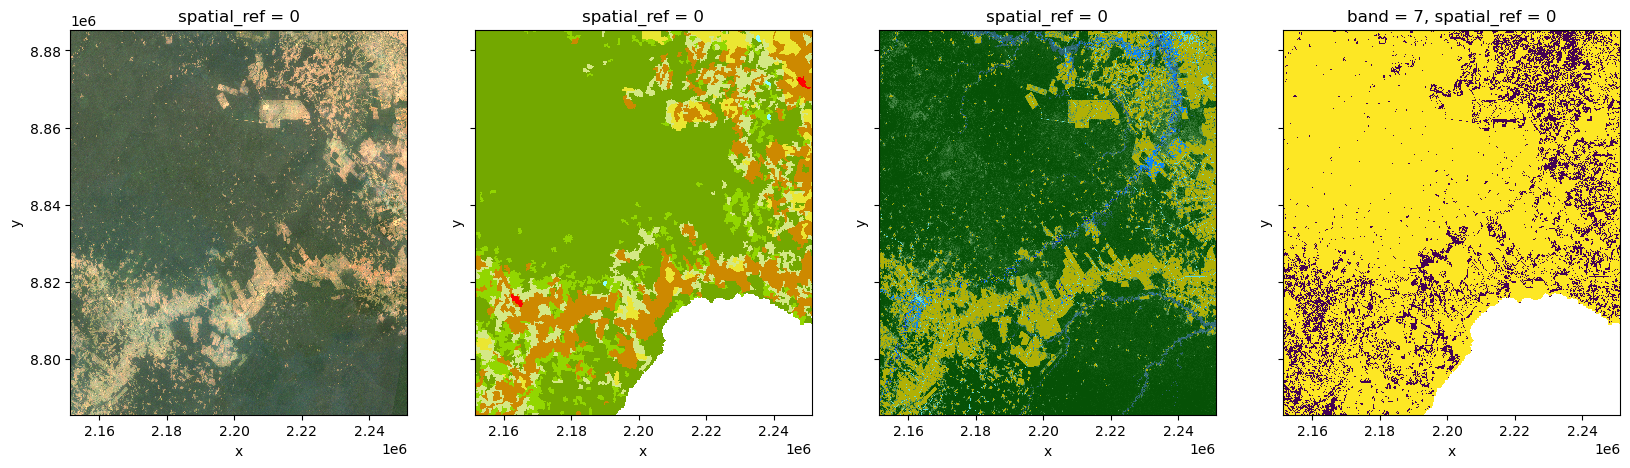

In [117]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 4, figsize=(20, 5), sharey=True)

(out.sel(band=[3,2,1]) * .2).astype(np.uint16).plot.imshow(ax = ax[0])

(lc_ibge_plot_ready).plot.imshow(ax = ax[1], add_colorbar = False)

lc_glc_plot_ready.plot.imshow(ax = ax[2], add_colorbar = False)

test.plot.imshow(ax = ax[3], add_colorbar = False)

---

In [ ]:
# vectorize land cover grid-wise
for i in tqdm([50]):#range(len(grid_data))
    # get grid cell
    cell = grid_data.iloc[[i]]
    
    # get imagery
    
    # file name
    def get_grid_name(cell):
        return "mapbiomas/2010_{:010d}-{:010d}.tif".format(*(cell[["Row", "Column"]].to_numpy() * 3328)[0])
    
    # Download a .tif file as bytes
    file_bytes = blobs[(file_names == get_grid_name(cell))][0].download_as_string()

    # Create a virtual file-like object
    virtual_file = io.BytesIO(file_bytes)

    # Open the virtual file as a rasterio dataset
    with rasterio.open(virtual_file) as dataset:
        imagery = rxr.open_rasterio(virtual_file)
        
    # get land cover data
    lc_data = lc.loc[lc.intersects(cell.geometry.iloc[0]), :]
    
    #
    
    bbox = gpd.GeoSeries(shapely.geometry.box(*cell.total_bounds), crs="EPSG:5641")
    geom = bbox.__geo_interface__["features"][0]["geometry"]
    geom["crs"] = {"properties": {"name": "EPSG:5641"}}
    
    # create xarray
    lc_xr = make_geocube(
        vector_data = lc_data,
        measurements = [f"USO{t}" for t in [2000, 2010, 2012, 2014, 2016, 2018, 2020]],
        output_crs = "EPSG:5641",
        fill = -1,
        geom = geom,
        align = (0, 0),
        resolution = [-30, 30]
    )
    lc_xr = lc_xr.astype(np.uint8, copy = False)
    
    # save to file
    #lc_xr.rio.to_raster(f"/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/land_cover/grid/ibge_{cell.CellID.iloc[0]}.tif")

100%|██████████| 1/1 [00:03<00:00,  3.06s/it]


In [4]:
test

<xarray.DataArray (band: 6, y: 3328, x: 3328)> Size: 266MB
[66453504 values with dtype=int32]
Coordinates:
  * band         (band) int64 48B 1 2 3 4 5 6
  * x            (x) float64 27kB 1.552e+06 1.552e+06 ... 1.652e+06 1.652e+06
  * y            (y) float64 27kB 1.058e+07 1.058e+07 ... 1.048e+07 1.048e+07
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      ('blue_median', 'green_median', 'red_median', 'nir_median...

In [ ]:
rxr.open_rasterio(base64.b64encode(test))

In [4]:


rxr.open_rasterio(base64.b64encode(test))

KeyboardInterrupt: 

In [ ]:
contents = blob.download_as_string()

In [ ]:
storage.Client(project='master-thesis-414809')

---

### Land Cover

In [26]:
import sqlite3
import numpy as np
import pandas as pd
import geopandas as gpd

import xarray as xr
import rioxarray as rxr
import shapely

from tqdm import tqdm

from geocube.api.core import make_geocube
from geocube.rasterize import rasterize_points_griddata

In [27]:
# connect to database
conn = sqlite3.connect('/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/imagery/imagery.db')
# get grid data
grid_data = pd.read_sql_query("SELECT * FROM GridCells WHERE Internal=1", conn)
# get grid geometries
grid_geoms = gpd.read_feather("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/imagery/grid_cells.feather")
# merge data
grid_data = gpd.GeoDataFrame(grid_data.merge(grid_geoms, on = "CellID"))
# close connection
conn.close()

In [28]:
# get land cover shapefile
lc = gpd.read_feather("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/land_cover/raw/Cobertura_uso_terra_Brasil_serie_revisada.feather")

In [32]:
# vectorize land cover grid-wise
for i in tqdm([50]):#range(len(grid_data))
    # get grid cell
    cell = grid_data.iloc[[i]]
    # get land cover data
    lc_data = lc.loc[lc.intersects(cell.geometry.iloc[0]), :]
    
    bbox = gpd.GeoSeries(shapely.geometry.box(*cell.total_bounds), crs="EPSG:5641")
    geom = bbox.__geo_interface__["features"][0]["geometry"]
    geom["crs"] = {"properties": {"name": "EPSG:5641"}}
    
    # create xarray
    lc_xr = make_geocube(
        vector_data = lc_data,
        measurements = [f"USO{t}" for t in [2000, 2010, 2012, 2014, 2016, 2018, 2020]],
        output_crs = "EPSG:5641",
        fill = -1,
        geom = geom,
        align = (0, 0),
        resolution = [-30, 30]
    )
    lc_xr = lc_xr.astype(np.uint8, copy = False)
    
    # save to file
    #lc_xr.rio.to_raster(f"/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/land_cover/grid/ibge_{cell.CellID.iloc[0]}.tif")

100%|██████████| 1/1 [00:03<00:00,  3.06s/it]


In [33]:
lc_xr

<xarray.Dataset> Size: 78MB
Dimensions:      (y: 3328, x: 3328)
Coordinates:
  * y            (y) float64 27kB 1.018e+07 1.018e+07 ... 1.008e+07 1.008e+07
  * x            (x) float64 27kB 2.451e+06 2.451e+06 ... 2.551e+06 2.551e+06
    spatial_ref  int64 8B 0
Data variables:
    USO2000      (y, x) uint8 11MB 255 255 255 255 255 255 255 ... 6 6 6 6 6 6 6
    USO2010      (y, x) uint8 11MB 255 255 255 255 255 255 255 ... 6 6 6 6 6 6 6
    USO2012      (y, x) uint8 11MB 255 255 255 255 255 255 255 ... 6 6 6 6 6 6 6
    USO2014      (y, x) uint8 11MB 255 255 255 255 255 255 255 ... 6 6 6 6 6 6 6
    USO2016      (y, x) uint8 11MB 255 255 255 255 255 255 255 ... 6 6 6 6 6 6 6
    USO2018      (y, x) uint8 11MB 255 255 255 255 255 255 255 ... 6 6 6 6 6 6 6
    USO2020      (y, x) uint8 11MB 255 255 255 255 255 255 255 ... 6 6 6 6 6 6 6

In [20]:
rxr.open_rasterio("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/land_cover/grid/ibge_213.tif")

<xarray.DataArray (band: 7, y: 3328, x: 3328)> Size: 78MB
[77529088 values with dtype=int8]
Coordinates:
  * band         (band) int64 56B 1 2 3 4 5 6 7
  * x            (x) float64 27kB 2.451e+06 2.451e+06 ... 2.551e+06 2.551e+06
  * y            (y) float64 27kB 1.018e+07 1.018e+07 ... 1.008e+07 1.008e+07
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    long_name:      ('USO2000', 'USO2010', 'USO2012', 'USO2014', 'USO2016', '...
    name:           USO2000
    _FillValue:     -1
    scale_factor:   1.0
    add_offset:     0.0

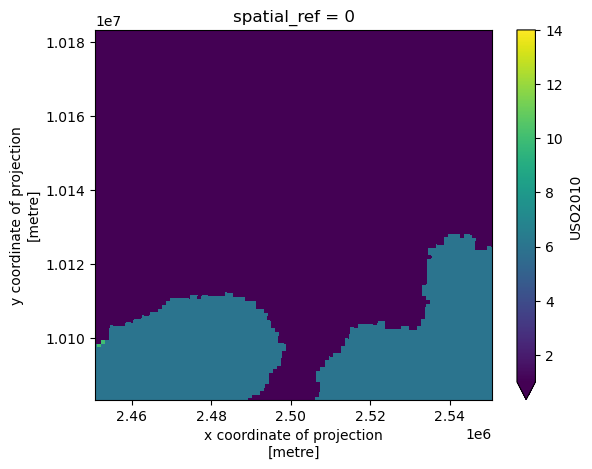

In [22]:
lc_xr.USO2010.plot.imshow(vmin = 1, vmax = 14)

#### ESA CCI

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd

import xarray as xr
import rioxarray as rxr

In [2]:
boundaries = gpd.read_file("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/boundaries/gadm_410-BRA.geojson",
                           engine = "pyogrio")

In [3]:
lc_esacci_300 = rxr.open_rasterio("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/land_cover/raw/scratch/ESACCI-LC-L4-LCCS-Map-300m-P1Y-1992_2015-v2.0.7.tif",
                                  chunks = True)

In [4]:
lc_esacci_300_2010_crop = lc_esacci_300.sel(band=(2010 - 1991)).rio.clip([boundaries.geometry.iloc[0]])

In [24]:
lc_esacci_300_2010_crop.drop_vars("band").rio.to_raster("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/land_cover/raw/scratch/ESACCI-LC-L4-LCCS-Map-300m-P1Y-2010-v2.0.7.tif")

In [7]:
lc_esacci_300_2010_crop.load()

<xarray.DataArray (y: 14044, x: 16250)> Size: 228MB
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
Coordinates:
    band         int64 8B 19
  * x            (x) float64 130kB -73.99 -73.98 -73.98 ... -28.86 -28.85 -28.85
  * y            (y) float64 112kB 5.262 5.26 5.257 ... -33.74 -33.74 -33.75
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    _FillValue:     0

In [12]:
np.unique(lc_esacci_300_2010_crop)

array([  0,  10,  11,  12,  20,  30,  40,  50,  60,  61,  62,  70,  80,
        90, 100, 110, 120, 130, 150, 153, 160, 170, 180, 190, 200, 210],
      dtype=uint8)

In [9]:
lc_esacci_300_2010_crop.rio.reproject("EPSG:5641")

<xarray.DataArray (y: 14423, x: 15914)> Size: 230MB
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
Coordinates:
  * x            (x) float64 127kB 1.553e+06 1.553e+06 ... 6.574e+06 6.574e+06
  * y            (y) float64 115kB 1.058e+07 1.058e+07 ... 6.032e+06 6.031e+06
    band         int64 8B 19
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    _FillValue:     0

#### Potapov et al. (2022) - Global 30m

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import sqlite3

import xarray as xr
import rioxarray as rxr

In [2]:
fetch_instructions = pd.read_json("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/setup/fetch.json")
def get_fetch_instructions(id):
    return fetch_instructions[fetch_instructions["id"] == id].to_dict(orient = "records")[0]

In [61]:
for f in get_fetch_instructions("lc_glc_30")["url"]["files"]:
    rxr.open_rasterio(f"/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/land_cover/raw/{f}", chunks = True).\
        rio.reproject("EPSG:4326").\
        rio.to_raster(f"/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/land_cover/raw/{f}")

In [3]:
shapefiles = [rxr.open_rasterio(f"/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/land_cover/raw/{f}", chunks = True) for f in get_fetch_instructions("lc_glc_30")["url"]["files"]]

In [4]:
shapefiles_combined = xr.combine_by_coords(shapefiles).sel(band = 1)

In [5]:
shapefiles_combined

<xarray.DataArray (y: 200000, x: 200000)> Size: 160GB
dask.array<getitem, shape=(200000, 200000), dtype=float32, chunksize=(3355, 40000), chunktype=numpy.ndarray>
Coordinates:
    band         int64 8B 1
  * x            (x) float64 2MB -80.0 -80.0 -80.0 -80.0 ... -30.0 -30.0 -30.0
  * y            (y) float64 2MB 10.0 10.0 9.999 9.999 ... -40.0 -40.0 -40.0
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [25]:
cell = grid_data.to_crs(4326).iloc[[0]]
cell_exterior = cell.exterior.iloc[0].coords.xy

In [15]:
cell_exterior

(array('d', [-61.42602898470794, -61.42602898470794, -62.32318033485499, -62.32318033485499, -61.42602898470794]),
 array('d', [5.264839452374542, 4.364880981938602, 4.364880981938602, 5.264839452374542, 5.264839452374542]))

In [52]:
shapefiles_combined_subset = shapefiles_combined.sel(
    dict(x = np.arange(cell_exterior[0][2] - 1, cell_exterior[0][1] + 1, 0.00025),
         y = np.arange(cell_exterior[1][1] - 1, cell_exterior[1][0] + 1, 0.00025)), 
    method = "nearest").load()

In [53]:
test = shapefiles_combined_subset.rio.reproject("EPSG:5641").reindex_like(lc_xr, method = "nearest")

In [54]:
np.unique(test)

array([48.], dtype=float32)

In [25]:
np.arange(min(cell_exterior[0]), max(cell_exterior[0]) + 30, 30)

array([2850255., 2850285., 2850315., ..., 2950005., 2950035., 2950065.])

In [26]:
np.arange(min(cell_exterior[1]), max(cell_exterior[1]) + 30, 30)

array([10482825., 10482855., 10482885., ..., 10582575., 10582605.,
       10582635.])

In [19]:
shapefiles_combined = shapefiles_combined.rio.clip([grid_data.iloc[0].geometry])

: 

: 

---

In [31]:
lc.loc[lc.intersects(grid_cell.geometry)]

,INDICE_GRE,USO2000,USO2010,USO2012,USO2014,USO2016,USO2018,USO2020,OBS,ID_GRE,geometry
8715318,1KME4147N11801,6,6,6,6,6,6,6,None,112353414711801,"POLYGON ((2942745.679 10482206.647, 2941767.88..."
8715319,1KME4147N11802,6,6,6,6,6,6,6,None,112353414711802,"POLYGON ((2942771.870 10483233.306, 2941794.10..."
8715320,1KME4147N11803,6,6,6,6,6,6,6,None,112353414711803,"POLYGON ((2942798.059 10484260.023, 2941820.32..."
8715321,1KME4147N11804,6,6,6,6,6,6,6,None,112353414711804,"POLYGON ((2942824.246 10485286.796, 2941846.54..."
8715322,1KME4147N11805,6,6,6,6,6,6,6,None,112353414711805,"POLYGON ((2942850.432 10486313.628, 2941872.75..."
...,...,...,...,...,...,...,...,...,...,...,...
8717978,1KME4152N11805,6,6,6,6,6,6,6,None,112353415211805,"POLYGON ((2947738.820 10486176.521, 2946761.13..."
8717979,1KME4152N11806,6,6,6,6,6,6,6,None,112353415211806,"POLYGON ((2947764.850 10487203.407, 2946787.20..."
8717980,1KME4152N11807,6,6,6,6,6,6,6,None,112353415211807,"POLYGON ((2947790.879 10488230.350, 2946813.26..."
8717981,1KME4152N11808,6,6,6,6,6,6,6,None,112353415211808,"POLYGON ((2947816.906 10489257.351, 2946839.31..."


<Axes: >

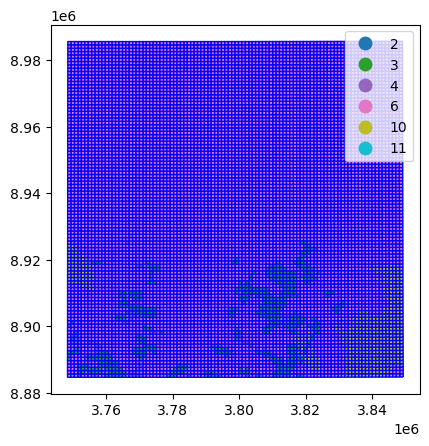

In [37]:
i = 500
grid_cell = grid_data.iloc[i]
lc.loc[lc.intersects(grid_cell.geometry)].plot(column = "USO2010", legend = True, edgecolor = "blue", categorical = True)

In [3]:
classes = pd.read_excel("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/land_cover/cobertura_uso_codigos_cores.xlsx")

In [6]:
def rasterize(gdf, value_col, boundaries):
    
    bbox = gpd.GeoSeries(shapely.geometry.box(*boundaries.to_crs("EPSG:5641").total_bounds), crs="EPSG:5641")
    geom = bbox.__geo_interface__["features"][0]["geometry"]
    geom["crs"] = {"properties": {"name": "EPSG:5641"}}
    
    return make_geocube(
        vector_data = gdf,
        measurements = value_col,
        geom=geom,
        output_crs = "EPSG:5641",
        align=[15, 15],
        resolution = [-30, 30],
        fill = -9999,
        #categorical_enums={v: list(range(1, max(classes.Codigo_Classe) + 1)) for v in variable}
    )

In [22]:
raster = rasterize(lc_clip, ["USO2010"], lc_subset) #[f"USO{t}" for t in [2000, 2010, 2012, 2014, 2016, 2018, 2020]]

In [23]:
raster

<xarray.Dataset> Size: 3GB
Dimensions:      (y: 16429, x: 24976)
Coordinates:
  * y            (y) float64 131kB 6.507e+06 6.507e+06 ... 6.014e+06 6.014e+06
  * x            (x) float64 200kB 3.48e+06 3.48e+06 ... 4.23e+06 4.23e+06
    spatial_ref  int64 8B 0
Data variables:
    USO2010      (y, x) float64 3GB -9.999e+03 -9.999e+03 ... -9.999e+03

In [24]:
raster.USO2010.plot.imshow(vmin = 1, vmax = 14)

: 

: 

In [25]:
raster.rio.crs

CRS.from_epsg(5641)

In [ ]:
ftp://geo10.elie.ucl.ac.be/CCI/LandCover/ESACCI-LC-L4-LCCS-Map-300m-P1Y-1992_2015-v2.0.7.zip

In [78]:
c = fiona.open("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/land_cover/raw/Cobertura_uso_terra_Brasil_serie_revisada.shp")
gpd.GeoDataFrame.from_features(c[0:1])

,geometry,INDICE_GRE,USO2000,USO2010,USO2012,USO2014,USO2016,USO2018,USO2020,OBS,ID_GRE
0,"POLYGON ((-52.09503 -32.45742, -52.09510 -32.4...",1KME5189N7749,13,13,13,13,13,13,13,None,11235351897749


In [81]:
len(c)

8752566

In [51]:
land_cover = gpd.read_file("/Users/felixschulz/Library/CloudStorage/OneDrive-Personal/Dokumente/Uni/Masterthesis/data/land_cover/Cobertura_uso_terra_Brasil_serie_revisada/Cobertura_uso_terra_Brasil_serie_revisada.shp")

KeyboardInterrupt: 

In [39]:
land_cover.set_index("REFNAME", inplace = True)

In [40]:
land_cover

,TEXT,DESCRIèãO,AREA,refn_descr,geometry
REFNAME,,,,,
AC_1.1.7398,AC_1.1.7398,Cidades,1.1033,AC_1.1.7398_Cidades,"POLYGON ((-67.67806 -10.58283, -67.67833 -10.5..."
AC_1.1.7398,AC_1.1.7398,Cidades,0.6579,AC_1.1.7398_Cidades,"POLYGON ((-69.55851 -10.93654, -69.55823 -10.9..."
AC_1.1.7398,AC_1.1.7398,Cidades,3.0128,AC_1.1.7398_Cidades,"POLYGON ((-68.75963 -10.98607, -68.75868 -10.9..."
AC_1.1.7398,AC_1.1.7398,Cidades,0.0036,AC_1.1.7398_Cidades,"POLYGON ((-70.04697 -10.97985, -70.04752 -10.9..."
AC_1.1.7398,AC_1.1.7398,Cidades,0.1215,AC_1.1.7398_Cidades,"POLYGON ((-70.04540 -10.98366, -70.04539 -10.9..."
...,...,...,...,...,...
AC_2.3.1,AC_2.3.1,Pecuária de animais de grande porte,0.1100,AC_2.3.1_Pecuária de animais de grande porte,"POLYGON ((-70.28406 -8.06527, -70.28406 -8.065..."
AC_2.3.1,AC_2.3.1,Pecuária de animais de grande porte,0.0475,AC_2.3.1_Pecuária de animais de grande porte,"POLYGON ((-70.28462 -8.06600, -70.28554 -8.066..."
AC_2.3.1,AC_2.3.1,Pecuária de animais de grande porte,0.0850,AC_2.3.1_Pecuária de animais de grande porte,"POLYGON ((-70.28302 -8.06814, -70.28357 -8.068..."


In [50]:
land_cover["DESCRIèãO"].unique()

array(['Cidades',
       'Cultivos temporários diversificados  + Pecuária animais de pequeno porte  + Extrativismo animal em área florestal',
       'Outros cultivos permanentes',
       'Pecuária de animais de grande porte',
       'Pecuária de animais de grande porte + Cultivos temporários diversificados',
       'Unidades de conservação de proteção integral em área florestal + Pecuária de animais de grande porte + Cultivos tempor',
       'Unidades de conservação de proteção integral em área florestal',
       'Unidades de conservação de uso sustentável  em área florestal',
       'Unidades de conservação de uso sustentável em área florestal + Cultivo agroflorestal',
       'Extrativismo vegetal em área florestal + Extrativismo animal em área florestal',
       'Extrativismo vegetal em área florestal + Cultivos temporários diversificados',
       'Frutíferas permanentes', 'Terra indígena em área florestal',
       'Aquicultura em corpo d\x92água continental',
       'Terra indígena 

<AxesSubplot: >

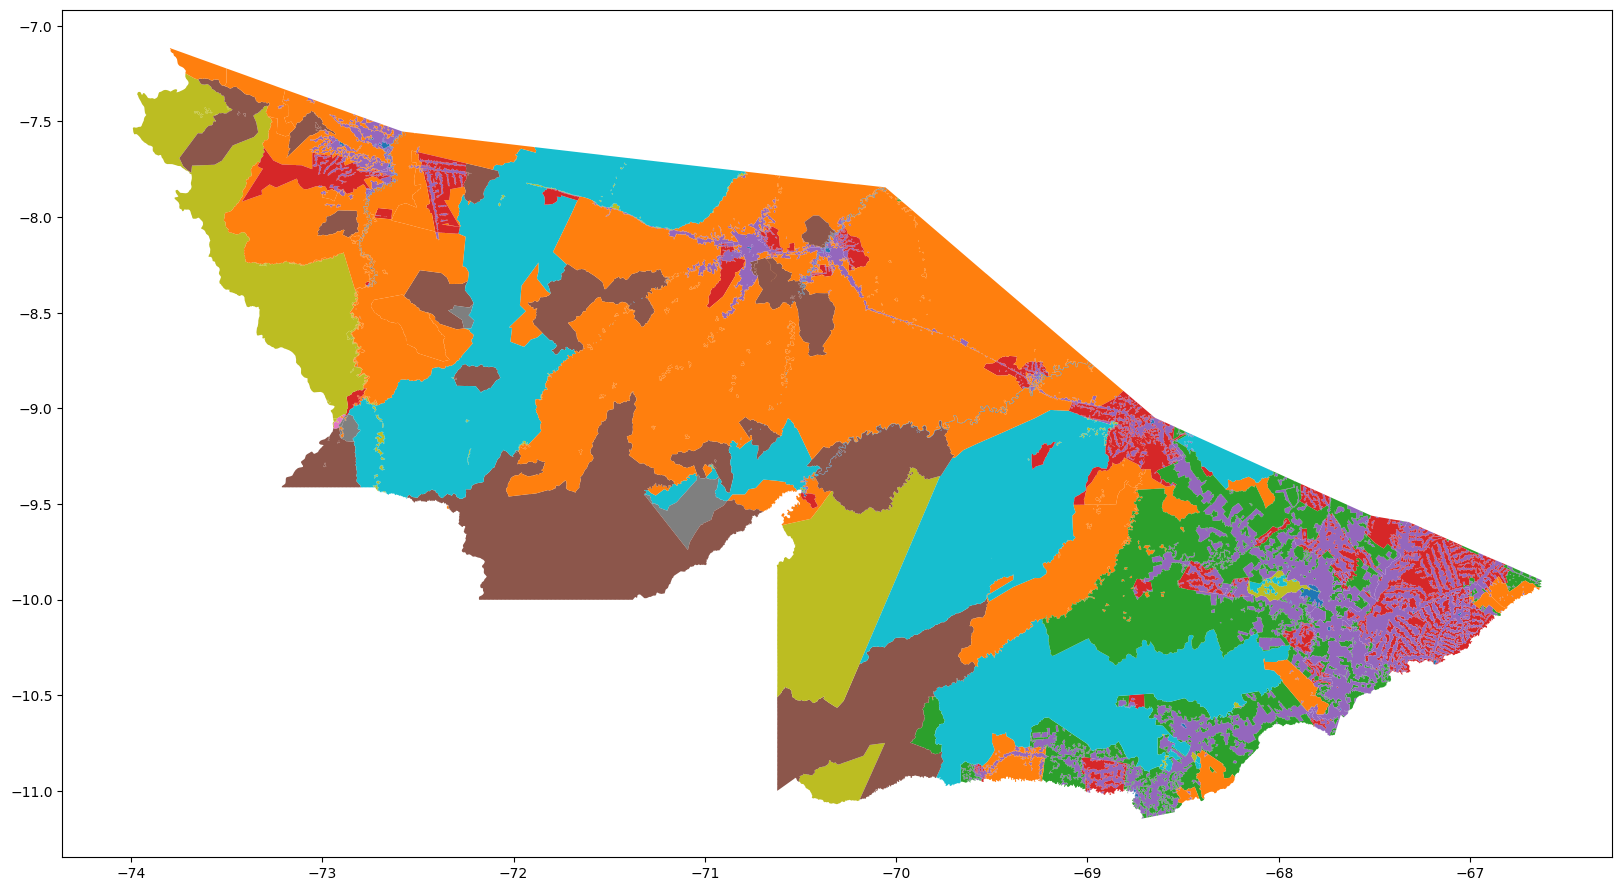

In [48]:
fig, ax = plt.subplots(1, 1, figsize = (20, 20))
land_cover.plot(column = "DESCRIèãO", ax = ax)

In [1]:
import pandas as pd
import geopandas as gpd

lulc = gpd.read_file('/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/land_cover/raw/Cobertura_uso_terra_Brasil_serie_revisada.shp')

KeyboardInterrupt: 

In [2]:
lulc = gpd.read_file('/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/land_cover/raw/Cobertura_uso_terra_Brasil_serie_revisada.shp',
                     rows = 1)

In [3]:
lulc

,INDICE_GRE,USO2000,USO2010,USO2012,USO2014,USO2016,USO2018,USO2020,OBS,ID_GRE,geometry
0,1KME5189N7749,13,13,13,13,13,13,13,None,11235351897749,"POLYGON ((-52.09503 -32.45742, -52.09510 -32.4..."


---

In [5]:
import numpy as np
import shapely
import geopandas as gpd
boundaries = gpd.read_file("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/boundaries/gadm_410-BRA.geojson").to_crs("EPSG:5641")

In [67]:
## create grid

# get boundaries
xmin, ymin, xmax, ymax = np.round(boundaries.total_bounds)

# grid dimensions
# 2**11 pixels times 30 meters per pixel
edge_size = 3328
length = edge_size * 30
width = edge_size * 30

# create grid
cols = list(np.arange(xmin, xmax + width, width))
rows = list(np.arange(ymin, ymax + length, length))


# create polygons for each grid cell
polygons = [shapely.Polygon([(x,y), (x+width, y), (x+width, y+length), (x, y+length)]) for y in rows[:-1] for x in cols[:-1]]

# create geodataframe      
grid = gpd.GeoDataFrame({'geometry': polygons}, crs = 5641)
grid = grid[grid.intersects(boundaries.geometry.iloc[0])]

In [68]:
grid.to_file(f"/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/boundaries/grid_{edge_size}.geojson", driver = "GeoJSON")

In [6]:
grid = gpd.read_file("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/boundaries/grid.geojson", driver = "GeoJSON")

<Axes: >

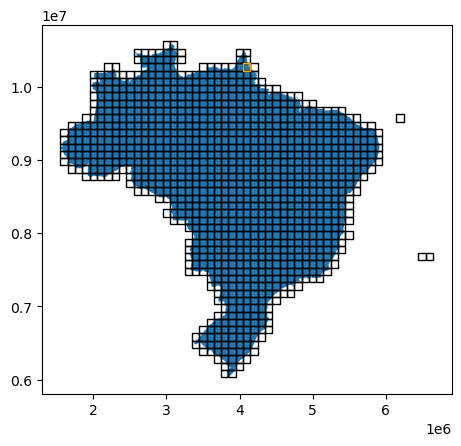

In [69]:
ax = boundaries.plot()
grid.plot(color = "none", edgecolor='black', ax = ax)
grid.iloc[[1000],:].plot(color = "none", edgecolor='orange', ax = ax)
#boundaries[:0].plot(color = "none", edgecolor='red', ax = ax)

In [40]:
import ee
#from geetools import batch

# Trigger the authentication flow.
ee.Authenticate()

True

In [41]:
# Initialize the library.
ee.Initialize(project='master-thesis-414809')

In [42]:
mb_mosaics = ee.ImageCollection('projects/nexgenmap/MapBiomas2/LANDSAT/BRAZIL/mosaics-2')

In [43]:
bands = [
      "blue_median",
      "green_median",
      "red_median",
      "nir_median",
      "swir1_median",
      "swir2_median",
  ]

In [44]:
def format_json(geometry, index):
    tmp = geometry.geometry.iloc[index].exterior.coords.xy
    return [tmp[0][0], tmp[1][0], tmp[0][2], tmp[1][2]]#np.array(json.loads(geometry.to_json())["features"][0]["geometry"]["coordinates"][0])[[0, 2]]
def get_ee_geometry(geometry, index):
    return ee.Geometry.Rectangle(format_json(geometry, index), proj = "EPSG:5641", evenOdd = False)
# def rev_coords(x):
#     return gpd.GeoSeries(shapely.Polygon([list(reversed(y)) for y in x.geometry.iloc[0].exterior.coords]))
# def get_ee_geometry_rev(geometry, index):
#     return ee.Geometry.Rectangle(format_json(rev_coords(geometry.to_crs(4326).iloc[[index]])), proj = "EPSG:4326",evenOdd = False)

In [45]:
#filterBounds(get_ee_geometry(grid, 16)).\ #clip(get_ee_geometry(grid, 16)).\ reproject(crs = "EPSG:5641", scale = 30).\
img = mb_mosaics.\
    filterMetadata("year", "equals", 2015).\
        select(bands).\
            mosaic().\
                int32()

In [45]:
test_settings = {
        "bands": 'red_median,green_median,blue_median',
        "gain": '.2,.2,.2',
        "gamma": 0.75
    }

In [46]:
import geemap.core as geemap

map_l8 = geemap.Map(center=[-8.086605614816632, -72.88518920555826], zoom=10)

# Add the image layer to the map and display it.
map_l8.add_layer(img, test_settings, 'false color composite')
display(map_l8)

Map(center=[-8.086605614816632, -72.88518920555826], controls=(ZoomControl(options=['position', 'zoom_in_text'…

In [24]:
projection = img.select("red_median").projection().getInfo()

In [25]:
projection

{'type': 'Projection', 'crs': 'EPSG:5641', 'transform': [30, 0, 0, 0, -30, 0]}

Margin: 24px

Image size: 256px-2*24px=208px

In [61]:
1e13 > (208*(2**12))**2

True

In [70]:
851968 ** 2

725849473024

In [66]:
(208*(2**4))

3328

In [52]:
1e13 > ((6574480.225607567 - 1552328.935599452) / 30) * ((10582639.255444987 - 6031349.390489734) / 30)

True

In [53]:
brazil_bounds = ee.Geometry.Rectangle(boundaries.bounds.to_numpy().tolist()[0], proj = "EPSG:5641", evenOdd = False)

In [54]:
256*4

1024

In [73]:
def export_image(year = 2015):
    task = ee.batch.Export.image.toCloudStorage(
        image=img,
        description=f'mapbiomas_{year}',
        bucket="master-thesis-lulc",
        fileNamePrefix=f'mapbiomas/{year}_',
        scale=30,
        maxPixels=1e13,
        crs="EPSG:5641",
        crsTransform=[30, 0, 0, 0, -30, 0],
        shardSize=208,
        fileDimensions=[3328, 3328],
        region=brazil_bounds,
        fileFormat='GeoTIFF'
        )
    task.start()

In [74]:
export_image()

In [13]:
import xarray as xr
import rioxarray as rxr

In [38]:
dat = rxr.open_rasterio("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/mapbiomas_2015_0.tif")

In [47]:
dat

<xarray.DataArray (band: 6, y: 8193, x: 8193)> Size: 2GB
array([[[ 222,  232, ...,  223,  217],
        [ 224,  233, ...,  246,  219],
        ...,
        [   0,    0, ...,    0,    0],
        [   0,    0, ...,    0,    0]],

       [[ 570,  589, ...,  427,  414],
        [ 584,  595, ...,  468,  447],
        ...,
        [   0,    0, ...,    0,    0],
        [   0,    0, ...,    0,    0]],

       ...,

       [[1939, 2039, ..., 1499, 1418],
        [2055, 2119, ..., 1733, 1519],
        ...,
        [   0,    0, ...,    0,    0],
        [   0,    0, ...,    0,    0]],

       [[ 920,  946, ...,  732,  655],
        [ 959,  973, ...,  825,  709],
        ...,
        [   0,    0, ...,    0,    0],
        [   0,    0, ...,    0,    0]]], dtype=int32)
Coordinates:
  * band         (band) int64 48B 1 2 3 4 5 6
  * x            (x) float64 66kB 3.518e+06 3.518e+06 ... 3.764e+06 3.764e+06
  * y            (y) float64 66kB 6.277e+06 6.277e+06 ... 6.031e+06 6.031e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      ('blue_median', 'green_median', 'red_median', 'nir_median...

In [44]:
dat.isin(0).sum()

<xarray.DataArray ()> Size: 8B
array(376607345)
Coordinates:
    spatial_ref  int64 8B 0

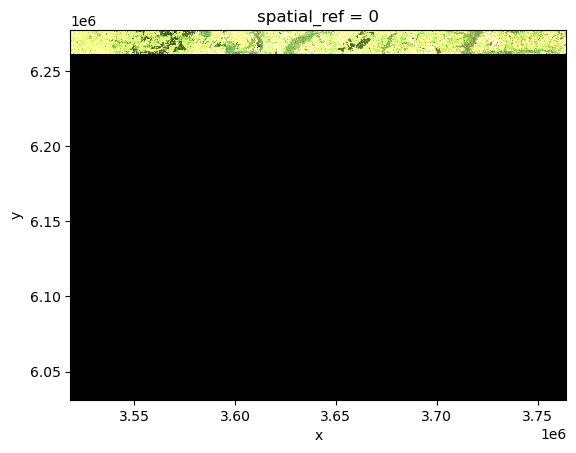

In [40]:
xr.plot.imshow(dat.sel(band = [3,2,1]), rgb = "band", robust = True)

In [1]:
import tensorflow as tf

2024-02-24 11:47:01.628217: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-24 11:47:02.098337: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-24 11:47:02.955931: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-24 11:47:02.955976: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-24 11:47:02.958861: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [2]:
dataset = tf.data.TFRecordDataset("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/mapbiomas_2015_100-1.tfrecord")